<a href="https://www.youtube.com/watch?v=oxEXBJQG27A&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=13"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to my YouTube Video - Debarta-v3-large model fine tuning for Kaggle Competition Feedback-Prize | NLP</b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/1ABKhG4.png)](https://www.youtube.com/watch?v=oxEXBJQG27A&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=13)


## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

## Kaggle Competition Link - https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview

In [1]:
import os
import gc
from tqdm.auto import tqdm

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px #graphing
import plotly.graph_objects as go #graphing
from plotly.subplots import make_subplots #graphing
import plotly.figure_factory as ff #graphing

from transformers import get_polynomial_decay_schedule_with_warmup,get_cosine_schedule_with_warmup,get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase
from transformers import DataCollatorWithPadding,DataCollatorForTokenClassification


from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs
from datasets import concatenate_datasets,load_dataset,load_from_disk

from sklearn.metrics import log_loss

from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from datasets import Dataset, load_from_disk
import pickle
import re
from transformers import TrainingArguments, AutoConfig, AutoModelForTokenClassification, DataCollatorForTokenClassification


In [3]:
base_dir = "/kaggle/working/"

ds_train_path = "../input/feedback-prize-english-language-learning/train.csv"

ds_test_path = "../input/feedback-prize-english-language-learning/test.csv"

sample_submission_path = "../input/feedback-prize-english-language-learning/sample_submission.csv"
    
save_dir="/kaggle/input/deverta-dhankhar-v20/"

deberta_v3_large_offline_path = "../input/deberta-v3-large/deberta-v3-large/"


In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Config

In [6]:
class config:
    base_dir = base_dir
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed = 69
    # dataset path 
    ds_train_path = ds_train_path
    ds_test_path = ds_test_path
    sample_submission_path = sample_submission_path
       
    save_dir=save_dir
    
    #tokenizer params
    truncation = True 
    padding = False #'max_length'
    max_length = 512
    
    # model params
    model_name = "microsoft/deberta-v3-large"
    target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    load_from_disk = None
    
    #training params
    learning_rate = 0.1
    batch_size = 5
    epochs = 5
    NFOLDS = 5

seed_everything(config.seed)

Global seed set to 69


69

# EDA

In [7]:
train_df = pd.read_csv(ds_train_path)
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


<AxesSubplot:>

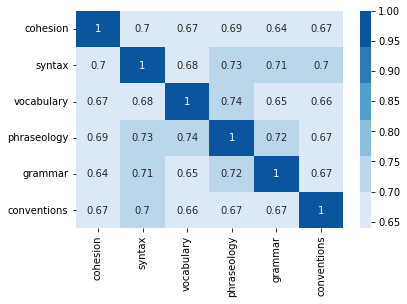

In [8]:
colormap = sns.color_palette('Blues')

sns.heatmap(train_df.corr(), annot = True, cmap = colormap )

In [9]:
fig = px.histogram(train_df, x = train_df['full_text'].str.len(), marginal = 'box', title  = 'Histogram of full_text text length', 
                  color_discrete_sequence = ["#FFA200"] )

fig.update_layout(bargap = 0.2)

fig.update_layout(template = 'plotly_dark', font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )

fig.show()

In [10]:
colors = [["#00E600"], ["#0000E6"], ["#E600DF"], ["#E6E600"], ["#FFFFFF"], ["#cd040b"]]


for count, x in enumerate(["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]):
    fig = px.histogram(train_df, x = x, marginal = 'violin', title = f" {x} histogram", color_discrete_sequence = colors[count]  )
    
    fig.update_layout(bargap = 0.2)
    fig.update_layout(template = 'plotly_dark', font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF" ) )
    
    fig.show() 
    
    

# Preprocessing

In [12]:
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode('utf-8'), error.end


# Read further - https://docs.python.org/3/library/codecs.html

def replace_decoding_with_cp1252(error : UnicodeError ) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode('cp1252'), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error('replace_encoding_with_utf8', replace_encoding_with_utf8)
codecs.register_error('replace_decoding_with_cp1252', replace_decoding_with_cp1252)


def resolve_encodings_and_normalize(text: str) -> str:
    text = (
        text.encode('raw_unicode_escape')
        .decode('utf-8', errors = 'replace_decoding_with_cp1252' )
        .decode('cp1252', errors = 'replace_encoding_with_utf8' )
        .decode('utf-8', errors = 'replace_decoding_with_cp1252' )
    )
    
    text = unidecode(text)
    return text




--------------------------------

## `replace_encoding_with_utf8()`


Source - https://www.oreilly.com/library/view/fluent-python/9781491946237/ch04.html


Character Issues
The concept of “string” is simple enough: a string is a sequence of characters. The problem lies in the definition of “character.”

In 2015, the best definition of “character” we have is a Unicode character. Accordingly, the items you get out of a Python 3 str are Unicode characters, just like the items of a unicode object in Python 2—and not the raw bytes you get from a Python 2 str.

The Unicode standard explicitly separates the identity of characters from specific byte representations:

The identity of a character—its code point—is a number from 0 to 1,114,111 (base 10), shown in the Unicode standard as 4 to 6 hexadecimal digits with a “U+” prefix. For example, the code point for the letter A is U+0041, the Euro sign is U+20AC, and the musical symbol G clef is assigned to code point U+1D11E. About 10% of the valid code points have characters assigned to them in Unicode 6.3, the standard used in Python 3.4.

The actual bytes that represent a character depend on the encoding in use. An encoding is an algorithm that converts code points to byte sequences and vice versa. The code point for A (U+0041) is encoded as the single byte \x41 in the UTF-8 encoding, or as the bytes \x41\x00 in UTF-16LE encoding. As another example, the Euro sign (U+20AC) becomes three bytes in UTF-8—\xe2\x82\xac—but in UTF-16LE it is encoded as two bytes: \xac\x20.


Further reading on this - https://docs.python.org/3/library/codecs.html

In [13]:
df_train = pd.read_csv(config.ds_train_path)
df_test = pd.read_csv(config.ds_test_path)
df_ss = pd.read_csv(config.sample_submission_path)

In [14]:
df_train.head(2)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5


In [ ]:
df_train['full_text'] = df_train['full_text'].apply(resolve_encodings_and_normalize)

df_test['full_text'] = df_test['full_text'].apply(resolve_encodings_and_normalize)

df_test[config.target_cols] = 0

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large_offline_path)

In [ ]:
def tokenize(df):
    """
    Tokenize the text data using a tokenizer.

    Args:
        df (DataFrame): Input DataFrame containing the text data.

    Returns:
        dict: Tokenized data containing input IDs, attention masks,
              labels, and length.

    """
    text = df['full_text']
    
    tokenized = tokenizer(text,
                          padding = config.padding,
                          truncation = True,
                          max_length = config.max_length
                          add_special_tokens = True
                         )
    tokenized['labels'] = [df[i] for i in config.target_cols ]
    tokenized['length'] = len(tokenized['input_ids'])
    
    return tokenized
    

In [ ]:
if config.load_from_disk is None:
    
    ds = Dataset.from_pandas(df_test)
    
    ds = ds.map(
        tokenize,
        batched=False,
        num_proc=4,
        desc='Tokenizing'
    )
    
    
ds.save_to_disk(f" {config.base_dir}data.dataset")

with open(f"{config.base_dir}_pkl", "wb" ) as fp:
    pickle.dump(df_test, fp)
    
    

## Mean Pooling


### The process of converting a sequence of embeddings into a sentence embedding is called “pooling”. 

![](2022-09-17-21-37-14.png)

In [ ]:
class MeanPooling(nn.Module):
    """
    Mean pooling module for NLP tasks.

    This module calculates the mean of the hidden state vectors
    based on the attention mask.

    """
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        """
        Forward pass of the mean pooling module.

        Args:
            last_hidden_state (torch.Tensor): Last hidden state from the transformer.
            attention_mask (torch.Tensor): Attention mask indicating valid tokens.

        Returns:
            torch.Tensor: Mean-pooled embeddings.

        """
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1 )
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min = 1e-9 )
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [ ]:
class DebartaLargeModel(pl.LightningModule):
    """
    This class is a PyTorch Lightning Module that uses the DeBERTa model for NLP tasks.

    Args:
        config: A dictionary containing the configuration parameters.
    """
    def __init__(self,config):
        super().__init__()
        self.cfg = config

        self.model_config = AutoConfig.from_pretrained(deberta_v3_large_offline_path + 'config.json')
        self.model_config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout_prob": 0.,
                "add_pooling_layer": False,
                "attention_probs_dropout_prob":0,
            }
        )
        
        self.transformers_model = AutoModel.from_pretrained(deberta_v3_large_offline_path, config=self.model_config)
        
        self.layer_norm = nn.LayerNorm(self.transformers_model.config.hidden_size * 2)  # Concat of mean and max pooling
        
        self.output = nn.Linear(self.transformers_model.config.hidden_size * 2, len(self.cfg.target_cols))   #  + num_external_features

        self.hidden_layer_weights = nn.Parameter(torch.zeros(self.model_config.num_hidden_layers).view(-1, 1, 1, 1))
        
        ''' Dropout layers 
        `nn.ModuleList` is just like a Python list. It was designed to store any desired number of nn.Module’s. 
        It may be useful, for instance, if you want to design a neural network whose number of layers is passed as input:

        So why use ModuleList instead of a normal python list? Ans - If you use a plain python list, 
        the parameters won’t be registered properly and you can’t pass them to your optimizer using model.parameters().
        '''

        self.dropouts = nn.ModuleList([
                nn.Dropout(0.1*i) for i in range(5)
            ])
        self.loss_function = nn.SmoothL1Loss(reduction='mean') 
        
    def forward(self, input_ids, attention_mask,train):
        """
        Defines the forward pass of the model.

        Args:
            input_ids: Tensor of input ids.
            attention_mask: Tensor of attention masks.
            train: Boolean indicating if the model is in training mode.

        Returns:
            Tuple of logits and _.
        """
        
        output_backbone = self.transformers_model(input_ids, attention_mask = attention_mask)#[0]
        
        hidden_states = output_backbone.hidden_states
        
        # Mean/max pooling (over hidden layers), concatenate with pooler
        hidden_states = torch.stack(tuple(hidden_states[-i-1] for i in range(len(hidden_states) - 1)), dim = 0)
        
        layer_weight = F.softmax(self.hidden_layer_weights, dim = 0)
        
        out_mean = torch.sum(hidden_states * layer_weight, dim = 0)
        
        out_max, _ = torch.max(hidden_states, dim = 0)
        
        # concatenate with pooler, i.e. Concat of mean and max pooling
        output_backbone = torch.cat((out_mean, out_max), dim = -1)
        
        output_backbone = self.layer_norm(output_backbone)[:,0,:]

        # print(output_backbone.shape) # torch.Size([3, 2048])
        
        # Multiple dropout
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                logits = self.output(output_backbone)
            else:
                logits += self.output(output_backbone)
        
        logits /= len(self.dropouts)
        return (logits, _)
    
        
    def train_dataloader(self):
        """
        Returns the training dataloader.

        Returns:
            DataLoader for the training data.
        """
        return self._train_dataloader 
    
    def validation_dataloader(self):
        """
        Returns the validation dataloader.

        Returns:
            DataLoader for the validation data.
        """
        return self._validation_dataloader

    #  we define a helper function to differentiate the parameters that should receive weight decay.
    def get_optimizer_params(self, encoder_lr, decoder_lr, weight_decay=0.0):
        """
        Helper function to get the parameters for the optimizer.

        Args:
            encoder_lr: Learning rate for the encoder.
            decoder_lr: Learning rate for the decoder.
            weight_decay: Weight decay rate.

        Returns:
            List of parameters for the optimizer.
        """
        
        param_optimizer = list(model.named_parameters())
        
        no_decay_list = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        # In general, biases and LayerNorm weights are not subject to weight decay:
        
        optimizer_parameters = [
            {'params': [p for n, p in self.transformers_model.named_parameters() if not any(nd in n for nd in no_decay_list)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            
            {'params': [p for n, p in self.transformers_model.named_parameters() if any(nd in n for nd in no_decay_list)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            
            {'params': [p for n, p in self.named_parameters() if "transformers_model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    def configure_optimizers(self):
        """
        Configures the optimizer for the training process.

        Returns:
            Dictionary containing the optimizer and the learning rate scheduler.
        """
        optimizer = AdamW(self.parameters(), lr = config.learning_rate)

        epoch_steps = self.cfg.data_length
        batch_size = self.cfg.batch_size

        # The idea of warmup_steps is to use some warmup steps to increase the learning rate 
        # up to a certain point and then use your normal learning rate decay afterwards. 
        warmup_steps = 0.09 * epoch_steps // batch_size
        training_steps = self.cfg.epochs * epoch_steps // batch_size
        # scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,training_steps,-1)
        scheduler = get_polynomial_decay_schedule_with_warmup(optimizer, warmup_steps, training_steps, lr_end=7e-7, power=3.0)

        lr_scheduler_config = {
                'scheduler': scheduler,
                'interval': 'step',
                'frequency': 1,
            }

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}
    
    

-------------------------------------


## `TORCH.TENSOR.EXPAND` - Explanations

Returns a new view of the self tensor with singleton dimensions expanded to a larger size.


```py
x = torch.tensor([[1], [2], [3]])
x.size()
# torch.Size([3, 1])

x.expand(3, 4)
'''
tensor([[ 1,  1,  1,  1],
        [ 2,  2,  2,  2],
        [ 3,  3,  3,  3]]) 
        
'''

```

Expanding a tensor does not allocate new memory, but only creates a new view on the existing tensor where a dimension of size one is expanded to a larger size by setting the stride to 0. Any dimension of size 1 can be expanded to an arbitrary value without allocating new memory.

-------------------------------------

--------------------------

--------------------------

## `torch.stack`  vs  `torch.cat` - Explanations

```python
t1 = torch.tensor([[1, 2],
                   [3, 4]])

t2 = torch.tensor([[5, 6],
                   [7, 8]])
```

`torch.stack`  |  `torch.cat`
--------------|---------------
**'Stacks'** a sequence of tensors along a new dimension: <br><br> [![enter image description here][1]][1] <br><br><br><br> | 'Con**cat**enates' a sequence of tensors along an existing dimension: <br><br> [![enter image description here][2]][2]

<sup>

These functions are analogous to [`numpy.stack`](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) and [`numpy.concatenate`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html).


</sup>

  [1]: https://i.stack.imgur.com/Ar9fu.png
  [2]: https://i.stack.imgur.com/RsEEq.png

-----------------------

### Printing `self.hidden_layer_weights` will produce the below 4-D Tensor -  - Explanations


```py
tensor([[[[-2.4625e-04]]],


        [[[ 9.4377e-05]]],


        [[[-8.3056e-05]]],


        ...,


        ]]]]

```

And the whole Tensor has a shape of **torch.Size([24, 1, 1, 1])**

----------


In [ ]:
def predict(data_loader, model):
    """
    Generates predictions using a trained model on the provided data loader.

    Args:
        data_loader (DataLoader): DataLoader containing the input data.
        model (torch.nn.Module): Trained model to use for prediction.

    Returns:
        numpy.ndarray: Array of predicted outputs.

    """
    model.to(config.device)
    model.eval()
    predictions = []
    
    for batch in tqdm(data_loader):
        with torch.no_grad():
            inputs = { key:val.reshape(val.shape[0], -1).to(config.device) for key, val in batch.items() }
            outputs = model(input_ids = inputs['input_ids'], attention_mask = inputs['attention_mask'], train = False )[0]
            
        predictions.extend(outputs.detach().cpu().numpy())
        
    predictions = np.vstack(predictions)
    
    return predictions
        
            

In [ ]:
collator = DataCollatorWithPadding(
    tokenizer = tokenizer, pad_to_multiple_of = 16, padding = 'longest'
)

for fold in range(config.NFOLDS):
    train_ds_list = []
    
    print(f"########### FOLD RUNNING {fold} ################ ")
    
    keep_cols = {"input_ids", "attention_mask", "labels"}
    
    test_ds = load_from_disk(f'{config.base_dir}data.dataset').sort('length')
    
    test_ds = test_ds.remove_columns([ c for c in test_ds.column_names if c not in keep_cols ])
    
    config.data_length = len(test_ds)
    
    test_dataloader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collator )
    
    
    model = DebertaLargeModel.load_from_checkpoint(f'{config.save_dir}microsoft/deberta-v3-large_{fold}.ckpt', train_dataloader = None, validation_dataloader = None, config = config  )
    
    preds = predict(test_dataloader, model )
    
    if fold == 0:
        final_preds = preds * (1/config.NFOLDS)
        
    else:
        final_preds += preds * (1/config.NFOLDS)
        
    del model, test_dataloader, test_ds
    gc.collect()
    torch.cuda.empty_cache()
    

In [ ]:
test_ids = []

test_ds = load_from_disk(f'{config.base_dir}data.dataset').sor('length')

for i in test_ds:
    test_ids.append(i['text_id'])
    
print(final_preds.shape)

sub_df = pd.DataFrame(test_ids, columns = {'text_id'} )

sub_df[config.target_cols] = final_preds.round(1)



In [ ]:
sub_df.head()

Pretrained Model Used in this NB

1. https://www.kaggle.com/datasets/hiromoon166/deberta-v3-large
2. https://www.kaggle.com/datasets/arkadius/deverta-dhankhar-v20